# Helper function used to plot the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Use matplotlib to create a plot and display the array values within the squares
def plot_value_policy(array1, array2):
  fig, ax = plt.subplots()

  # Custom colors for specific squares
  special_colors = {
      (0, 1): 'blue',
      (0, 4): 'green',
      (4, 2): 'red',
      (4, 4): 'yellow',
      (2, 4): 'black',
      (4, 0): 'black'
  }

  # Loop over data dimensions and create text annotations and colored squares.
  for (i, j), val in np.ndenumerate(array1):
      # Default color is white
      color = 'white'
      if (i, j) in special_colors:
          color = special_colors[(i, j)]
      # Add a colored rectangle for all cells, default or special color
      ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))
      # Add text annotations for both arrays
      ax.text(j, 4-i, f'{array1[i, j]}\n\n{array2[i, j]}', ha='center', va='center', color='black')

  # Hide the x and y axes
  ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
  ax.set_yticks(np.arange(-0.5, 5, 1), minor=True)
  ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
  ax.tick_params(which="minor", size=0)

  ax.set_xticks([])
  ax.set_yticks([])
  return fig,ax



In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot(array):
# Step 2: Use matplotlib to create a plot and display the array values within the squares
  fig, ax = plt.subplots()

  # Custom colors for specific squares
  special_colors = {
      (0, 1): 'blue',
      (0, 4): 'green',
      (4, 2): 'red',
      (4, 4): 'yellow',
      (2, 4): 'black',
      (4, 0): 'black'
  }

  # Loop over data dimensions and create text annotations and colored squares.
  for (i, j), val in np.ndenumerate(array):
      # Default color is white
      color = 'white'
      if (i, j) in special_colors:
          color = special_colors[(i, j)]
      # Add a colored rectangle for all cells, default or special color
      ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))
      ax.text(j, 4-i, f'{val}', ha='center', va='center', color='black')

  # Hide the x and y axes
  ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
  ax.set_yticks(np.arange(-0.5, 5, 1), minor=True)
  ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
  ax.tick_params(which="minor", size=0)

  ax.set_xticks([])
  ax.set_yticks([])

  return fig,ax


# Question 1

## Monte Carlo with Exploring Starts

<ipython-input-1-1485fb6fa8a0>:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


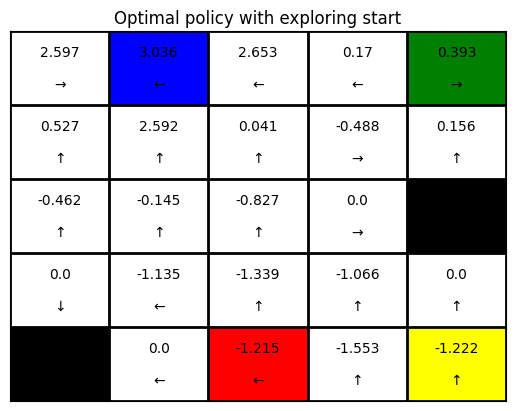

In [3]:
import numpy as np
import random

# Define parameters
grid_size = 5
gamma = 0.95
actions = ['up', 'down', 'left', 'right']
epsilon = 0.1  # for epsilon-soft policy
episodes = 10000
reward_off_grid = -0.5
reward_move = -0.2  # reward for moving from a white square to another white square

# Define special squares
blue_square = (0, 1)
green_square = (0, 4)
red_square = (4, 2)
yellow_square = (4, 4)
black_squares = [(2, 4), (4, 0)]

# Helper functions
def state_index(row, col):
    return row * grid_size + col

def is_terminal(state):
    return state in black_squares

def get_next_state_and_reward(row, col, action):
    next_row, next_col = (0,1)
    if action == 0:
        next_row, next_col = (row - 1, col) if row > 0 else (row, col)
    elif action == 1:
        next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
    elif action == 2:
        next_row, next_col = (row, col - 1) if col > 0 else (row, col)
    elif action == 3:
        next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

    if (row, col) == blue_square:
        return red_square[0], red_square[1], 5
    elif (row, col) == green_square:
        if np.random.rand() < 0.5:
            return red_square[0], red_square[1], 2.5
        else:
            return yellow_square[0], yellow_square[1], 2.5
    elif (next_row, next_col) in black_squares:
        return next_row, next_col, 0
    elif (row == next_row) and (col == next_col):
        return next_row, next_col, reward_off_grid
    else:
        return next_row, next_col, reward_move

def epsilon_greedy_policy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(len(actions)))
    else:
        return np.argmax(Q[state[0], state[1], :])

# Monte Carlo with Exploring Starts
def monte_carlo_exploring_starts(episodes, gamma):
    # Initialize Q-value, policy and returns
    Q = np.zeros((grid_size, grid_size, len(actions)))
    returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]
    policy = np.zeros((grid_size, grid_size), dtype=int)
    max_Q = np.zeros((grid_size, grid_size))

    for episode in range(episodes):
        episode_states_actions_rewards = []

        # Random starting state and action
        start_row, start_col = np.random.randint(grid_size), np.random.randint(grid_size)
        # If the chosen state is terminal state, we need to randomly choose another state
        while (start_row, start_col) in black_squares:
          start_row, start_col = np.random.randint(grid_size), np.random.randint(grid_size)
        start_action = np.random.choice(range(len(actions)))
        state = (start_row, start_col)
        action = start_action

        # Generate an episode
        while True:
            result = get_next_state_and_reward(state[0], state[1], action)
            next_row, next_col, reward = result
            episode_states_actions_rewards.append((state, action, reward))
            if is_terminal((next_row, next_col)):
              break
            state = (next_row, next_col)
            action = np.random.choice(range(len(actions)))

        G = 0
        visited_state_action_pairs = set()
        # Loop for the generated episode
        for (state, action, reward) in reversed(episode_states_actions_rewards):
            G = gamma * G + reward
            if (state, action) not in visited_state_action_pairs:
                returns[state_index(state[0], state[1])][action].append(G)
                Q[state[0], state[1], action] = np.mean(returns[state_index(state[0], state[1])][action])
                policy[state[0], state[1]] = np.argmax(Q[state[0], state[1], :])
                max_Q[state[0], state[1]] = np.max(Q[state[0], state[1], :])    # Return the max Q
                visited_state_action_pairs.add((state, action))

    # For policy illustration
    policy_symbols_exploring_starts = np.array([['↑', '↓', '←', '→'][policy[row, col]] for row in range(grid_size) for col in range(grid_size)])
    policy_symbols_exploring_starts = policy_symbols_exploring_starts.reshape((grid_size, grid_size))
    for state in black_squares:
        policy_symbols_exploring_starts[state[0], state[1]] = 'X'
    return policy_symbols_exploring_starts, max_Q

# Run Monte Carlo with Exploring Starts
policy_exploring_starts, value_exploring_starts = monte_carlo_exploring_starts(episodes, gamma)

# Plot the data
plot_exploring_starts,ax_vi = plot_value_policy(np.round(value_exploring_starts, decimals=3), policy_exploring_starts)
ax_vi.title.set_text('Optimal policy with exploring start')
plt.show()

## Monte Carlo method with ε-soft approach

<ipython-input-1-1485fb6fa8a0>:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


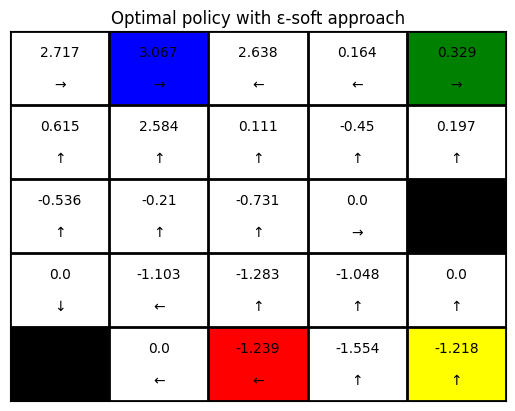

In [4]:
import numpy as np
import random

# Define parameters
grid_size = 5
gamma = 0.95
actions = ['0','1','2','3']
epsilon = 0.1  # for epsilon-soft policy
episodes = 10000
reward_off_grid = -0.5
reward_move = -0.2  # reward for moving from a white square to another white square

# Define special squares
blue_square = (0, 1)
green_square = (0, 4)
red_square = (4, 2)
yellow_square = (4, 4)
black_squares = [(2, 4), (4, 0)]

# Helper functions
def state_index(row, col):
    return row * grid_size + col

def is_terminal(state):
    return state in black_squares

def get_next_state_and_reward(row, col, action):
    next_row, next_col = (0,1)
    if action == 0:
        next_row, next_col = (row - 1, col) if row > 0 else (row, col)
    elif action == 1:
        next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
    elif action == 2:
        next_row, next_col = (row, col - 1) if col > 0 else (row, col)
    elif action == 3:
        next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

    if (row, col) == blue_square:
        return red_square[0], red_square[1], 5
    elif (row, col) == green_square:
        if np.random.rand() < 0.5:
            return red_square[0], red_square[1], 2.5
        else:
            return yellow_square[0], yellow_square[1], 2.5
    elif (next_row, next_col) in black_squares:
        return next_row, next_col, 0
    elif (row == next_row) and (col == next_col):
        return next_row, next_col, reward_off_grid
    else:
        return next_row, next_col, reward_move

def epsilon_greedy_policy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(len(actions)))
    else:
        return np.argmax(Q[state[0], state[1], :])

# Monte Carlo with epsilon-soft policies
def monte_carlo_epsilon_soft(episodes, gamma, epsilon):
    # Initialize Q-value and returns
    Q = np.random.rand(grid_size, grid_size, len(actions))
    Q_max = np.zeros((grid_size, grid_size))
    returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]
    policy = np.random.rand(grid_size, grid_size, len(actions)) + epsilon / len(actions)
    for episode in range(episodes):
        episode_states_actions_rewards = []

        # Random starting state
        start_row, start_col = np.random.randint(grid_size), np.random.randint(grid_size)
        while (start_row, start_col) in black_squares:
            start_row, start_col = np.random.randint(grid_size), np.random.randint(grid_size)
        state = (start_row, start_col)

        while True:
            action = np.random.choice(range(len(actions)))
            p=policy[state[0], state[1], :]
            next_row, next_col, reward = get_next_state_and_reward(state[0], state[1], action)
            episode_states_actions_rewards.append((state, action, reward))
            if is_terminal((next_row, next_col)):
                break
            state = (next_row, next_col)

        G = 0
        visited_state_action_pairs = set()
        for (state, action, reward) in reversed(episode_states_actions_rewards):
            G = gamma * G + reward
            if (state, action) not in visited_state_action_pairs:
                returns[state_index(state[0], state[1])][action].append(G)
                Q[state[0], state[1], action] = np.mean(returns[state_index(state[0], state[1])][action])

                # Update policy to be epsilon-soft
                best_action = np.argmax(Q[state[0], state[1], :])
                Q_max[state[0], state[1]] = np.max(Q[state[0], state[1], :])
                for a in range(len(actions)):
                    if a == best_action:
                        policy[state[0], state[1], a] = 1 - epsilon + (epsilon / len(actions))
                    else:
                        policy[state[0], state[1], a] = epsilon / len(actions)

                visited_state_action_pairs.add((state, action))

    return policy, Q_max

# Solve the gridworld problem
policy, q_max = monte_carlo_epsilon_soft(episodes, gamma, epsilon)

# Display the learned policy
policy_grid = np.zeros((grid_size, grid_size), dtype=int)
for row in range(grid_size):
    for col in range(grid_size):
      policy_grid[row, col] = actions[np.argmax(policy[row, col])]


policy_symbols_epsilon_soft = np.array([['↑', '↓', '←', '→'][int(policy_grid[row, col])] for row in range(grid_size) for col in range(grid_size)])
policy_symbols_epsilon_soft = policy_symbols_epsilon_soft.reshape((grid_size, grid_size))
for state in black_squares:
  policy_symbols_epsilon_soft[state[0], state[1]] = 'X'


# Plot the data
plot_epsilon, ax_epsilon = plot_value_policy(np.round(q_max, decimals=3), policy_symbols_epsilon_soft)
ax_epsilon.title.set_text('Optimal policy with ε-soft approach')
plt.show()


# Question 2

## Off-policy Monte Carolo implementation

<ipython-input-2-8e01290c3d6b>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


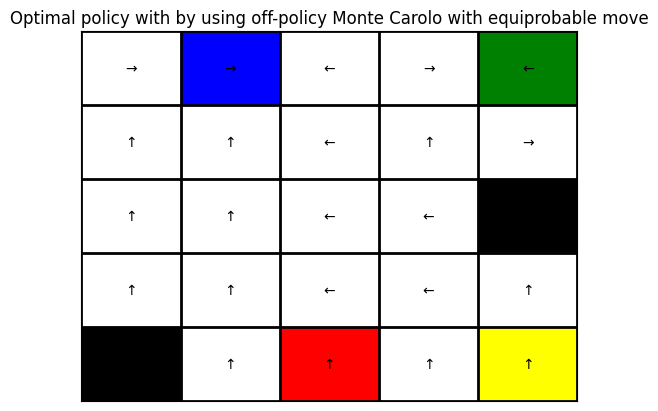

In [5]:
import numpy as np
import random

# Define parameters
grid_size = 5
gamma = 0.95
actions = ['up', 'down', 'left', 'right']
episodes = 100000
reward_off_grid = -0.5
reward_move = -0.2  # reward for moving from a white square to another white square
epsilon = 0.2

# Define special squares
blue_square = (0, 1)
green_square = (0, 4)
red_square = (4, 2)
yellow_square = (4, 4)
black_squares = [(2, 4), (4, 0)]

# Initialize Q-value and returns
Q = np.zeros((grid_size, grid_size, len(actions)))
target_policy = np.zeros((grid_size, grid_size))
C = np.zeros((grid_size, grid_size, len(actions)))  # Cumulative sum of weights
for row in range(grid_size):
    for col in range(grid_size):
      target_policy[row,col] = np.argmax(Q[row, col, :])

# Helper functions
def state_index(row, col):
    return row * grid_size + col

def is_terminal(state):
    return state in black_squares

def get_next_state_and_reward(row, col, action):
    #next_row, next_col = (0,0)
    if action == 0:
        next_row, next_col = (row - 1, col) if row > 0 else (row, col)
    elif action == 1:
        next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
    elif action == 2:
        next_row, next_col = (row, col - 1) if col > 0 else (row, col)
    elif action == 3:
        next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

    if (row, col) == blue_square:
        return red_square[0], red_square[1], 5
    elif (row, col) == green_square:
        if np.random.rand() < 0.5:
            return red_square[0], red_square[1], 2.5
        else:
            return yellow_square[0], yellow_square[1], 2.5
    elif (next_row, next_col) in black_squares:
        return next_row, next_col, 0
    elif (row == next_row) and (col == next_col):
        return next_row, next_col, reward_off_grid
    else:
        return next_row, next_col, reward_move

# Off-policy Monte Carlo control using weighted importance sampling
def monte_carlo_importance_sampling(episodes, gamma):
    policy = np.zeros((grid_size, grid_size, len(actions)))
    for episode in range(episodes):
        episode_states_actions_rewards = []

        # Initial state
        start_row, start_col = np.random.randint(grid_size), np.random.randint(grid_size)
        while (start_row, start_col) in black_squares:
          start_row, start_col = np.random.randint(grid_size), np.random.randint(grid_size)
        state = (start_row, start_col)

        while True:
            action = random.choice(range(len(actions))) # Equiprobable moves
            next_row, next_col, reward = get_next_state_and_reward(state[0], state[1], action)
            episode_states_actions_rewards.append((state, action, reward))
            if is_terminal((next_row, next_col)):
                break
            else:
              state = (next_row, next_col)
        G = 0
        W = 1
        visited_state_action_pairs = set()
        for (state, action, reward) in reversed(episode_states_actions_rewards):
          if W==0:
            break
          G = gamma * G + reward
          if (state, action) not in visited_state_action_pairs:
            C[state[0], state[1], action] += W
            Q[state[0], state[1], action] += (W / C[state[0], state[1], action]) * (G - Q[state[0], state[1], action])
            # Update policy to be epsilon-soft
            best_action = np.argmax(Q[state[0], state[1], :])
            for a in range(len(actions)):
                if a == best_action:
                    policy[state[0], state[1], a] = 1 - epsilon + (epsilon / len(actions))
                else:
                    policy[state[0], state[1], a] = epsilon / len(actions)
            W *= policy[state[0], state[1], action]/0.25 # Equiprobable behavior policy
          else:
            break
          visited_state_action_pairs.add((state, action))

    # Extract the optimal policy
    for row in range(grid_size):
        for col in range(grid_size):
          target_policy[row,col] = np.argmax(policy[row,col,:])
    return target_policy

# Run Monte Carlo with importance sampling
optimal_policy = monte_carlo_importance_sampling(episodes, gamma)

# Print the policy
policy_symbols = np.array([['↑', '↓', '←', '→'][int(optimal_policy[row, col])] for row in range(grid_size) for col in range(grid_size)])
policy_symbols = policy_symbols.reshape((grid_size, grid_size))

# Plot the data
plot_off_MC, ax_off_MC = plot(policy_symbols)
ax_off_MC.title.set_text('Optimal policy with by using off-policy Monte Carolo with equiprobable move')
plt.show()

## Q-learning implementation

<ipython-input-1-1485fb6fa8a0>:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


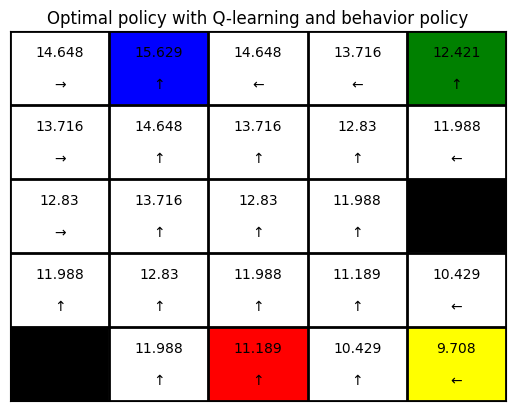

In [6]:
import numpy as np
import random

# Define parameters
grid_size = 5
gamma = 0.95
alpha = 0.1
epsilon = 0.1
actions = ['up', 'down', 'left', 'right']
reward_off_grid = -0.5
reward_move = -0.2
episodes = 10000
max_steps_per_episode = 1000

# Define special squares
blue_square = (0, 1)
green_square = (0, 4)
red_square = (4, 2)
yellow_square = (4, 4)
black_squares = [(2, 4), (4, 0)]

# Initialize Q-values
Q = np.random.rand(grid_size, grid_size, len(actions))

for state in black_squares:
    Q[state[0], state[1], :] = 0

# Helper functions
def epsilon_greedy_policy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(len(actions)))
    else:
        return np.argmax(Q[state[0], state[1], :])

def is_terminal(state):
    return state in black_squares

def get_next_state_and_reward(row, col, action):
    next_row, next_col = row, col
    if action == 0:
        next_row = max(row - 1, 0)
    elif action == 1:
        next_row = min(row + 1, grid_size - 1)
    elif action == 2:
        next_col = max(col - 1, 0)
    elif action == 3:
        next_col = min(col + 1, grid_size - 1)

    if (row, col) == blue_square:
        return red_square[0], red_square[1], 5
    elif (row, col) == green_square:
        if np.random.rand() < 0.5:
            return red_square[0], red_square[1], 2.5
        else:
            return yellow_square[0], yellow_square[1], 2.5
    elif (next_row, next_col) in black_squares:
        return next_row, next_col, 0
    elif (row == next_row) and (col == next_col):
        return next_row, next_col, reward_off_grid
    else:
        return next_row, next_col, reward_move

# Q-learning with equiprobable behavior policy
def q_learning_with_behavior_policy(episodes, gamma, alpha, epsilon):
    for episode in range(episodes):
        row, col = np.random.randint(grid_size), np.random.randint(grid_size)
        while (row, col) in black_squares:
          row, col = np.random.randint(grid_size), np.random.randint(grid_size)
        state = (row, col)
        steps = 0

        while steps < max_steps_per_episode:
            if is_terminal(state):
                break
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_row, next_col, reward = get_next_state_and_reward(row, col, action)
            Q_list = []
            for action_test in range(len(actions)):
              Q_list.append(Q[next_row, next_col, action_test])
            Q_list = np.array(Q_list)
            td_target = reward + gamma * np.max(Q_list)
            td_error = td_target - Q[row, col, action]
            Q[row, col, action] += alpha * td_error

            state = (next_row, next_col)
            row, col = next_row, next_col
            steps += 1

    # Extract the optimal policy
    policy = np.zeros((grid_size, grid_size), dtype=int)
    Q_value = np.zeros((grid_size, grid_size))
    for row in range(grid_size):
        for col in range(grid_size):
            policy[row, col] = np.argmax(Q[row, col, :])
            Q_value[row,col] = np.max(Q[row, col, :])
    return policy, Q_value

# Run Q-learning with behavior policy
optimal_policy, optimal_Q = q_learning_with_behavior_policy(episodes, gamma, alpha, epsilon)

# Print the policy in grid format
policy_symbols = np.array([['↑', '↓', '←', '→'][optimal_policy[row, col]] for row in range(grid_size) for col in range(grid_size)])
policy_symbols = policy_symbols.reshape((grid_size, grid_size))
for state in black_squares:
    policy_symbols[state[0], state[1]] = 'X'


# Plot the data
plot_behaviour, ax_behaviour = plot_value_policy(np.round(optimal_Q, decimals=3), policy_symbols)
ax_behaviour.title.set_text('Optimal policy with Q-learning and behavior policy')
plt.show()


# Question 3

## Code implementation, with permutation probability = 0.1

<ipython-input-1-1485fb6fa8a0>:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


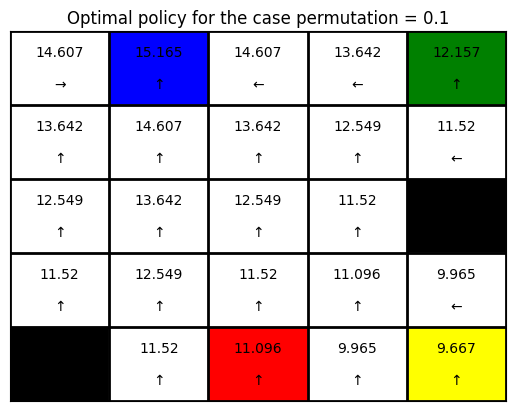

In [7]:
import numpy as np
import random

# Define parameters
grid_size = 5
gamma = 0.95
actions = ['up', 'down', 'left', 'right']
reward_off_grid = -0.5
reward_move = -0.2
max_iterations = 1000

# Define special squares
initial_blue_square = (0, 1)
initial_green_square = (0, 4)
red_square = (4, 2)
yellow_square = (4, 4)
black_squares = [(2, 4), (4, 0)]

# Initialize policy and value functions

# Helper functions
def is_terminal(state):
    return state in black_squares

def get_next_state_and_reward(row, col, action, blue_square, green_square):
    (next_row, next_col) = (row, col)
    if action == 0:
        next_row = max(row - 1, 0)
    elif action == 1:
        next_row = min(row + 1, grid_size - 1)
    elif action == 2:
        next_col = max(col - 1, 0)
    elif action == 3:
        next_col = min(col + 1, grid_size - 1)

    if (row, col) == blue_square:
        return red_square[0], red_square[1], 5
    elif (row, col) == green_square:
        if np.random.rand() < 0.5:
            return red_square[0], red_square[1], 2.5
        else:
            return yellow_square[0], yellow_square[1], 2.5
    elif (next_row, next_col) in black_squares:
        return next_row, next_col, 0
    elif (row == next_row) and (col == next_col):
        return next_row, next_col, reward_off_grid
    else:
        return next_row, next_col, reward_move

def policy_evaluation(policy, value_function, gamma, initial_blue_square, initial_green_square, permutation_probability, theta=0.8):
    while True:
        delta = 0
        blue_square = initial_blue_square
        green_square = initial_green_square
        new_value_function = np.copy(value_function)
        for row in range(grid_size):
            for col in range(grid_size):
                if is_terminal((row, col)):
                    continue

                # Permutation at every step
                if random.random() < permutation_probability:
                  blue_square, green_square = green_square, blue_square

                v = value_function[row, col]
                action = policy[row, col]
                next_row, next_col, reward = get_next_state_and_reward(row, col, action, blue_square, green_square)
                if (row,col)==green_square:
                  new_value_function[row, col] = 0.5*(reward + gamma * value_function[yellow_square[0], yellow_square[1]])\
                                                + 0.5*(reward + gamma * value_function[red_square[0], red_square[1]])
                else:
                  new_value_function[row, col] = reward + gamma * value_function[next_row, next_col]
                delta = max(delta, abs(v - new_value_function[row, col]))
        value_function = new_value_function
        if delta < theta:
            break
    return value_function

def policy_improvement(policy, value_function, gamma, initial_blue_square, initial_green_square, permutation_probability):
    policy_stable = True
    blue_square = initial_blue_square
    green_square = initial_green_square
    for row in range(grid_size):
        for col in range(grid_size):
            if is_terminal((row, col)):
                continue
            old_action = policy[row, col]
            action_values = np.zeros(len(actions))
            for action in range(len(actions)):
                # Permutation at every step
                if random.random() < permutation_probability:
                  blue_square, green_square = green_square, blue_square

                next_row, next_col, reward = get_next_state_and_reward(row, col, action, blue_square, green_square)
                if (row,col)==green_square:
                  action_values[action] = 0.5*(reward + gamma * value_function[yellow_square[0], yellow_square[1]]) \
                                        + 0.5*(reward + gamma * value_function[red_square[0], red_square[1]])
                else:
                  action_values[action] = reward + gamma * value_function[next_row, next_col]
            best_action = np.argmax(action_values)
            policy[row, col] = best_action
            if old_action != best_action:
                policy_stable = False
    return policy, policy_stable

def policy_iteration(policy, value_function, blue_square, green_square, gamma, permutation_probability):
    policy_stable = False
    while not policy_stable:
        value_function = policy_evaluation(policy, value_function, gamma, blue_square, green_square, permutation_probability)
        policy, policy_stable = policy_improvement(policy, value_function, gamma, blue_square, green_square, permutation_probability)
    return policy, value_function

# Main loop for policy iteration with permutation
def run_policy_iteration_with_permutation(episodes, gamma, permutation_probability):
    policy = np.zeros((grid_size, grid_size), dtype=int)
    value_function = np.zeros((grid_size, grid_size))
    for state in black_squares:
        value_function[state[0], state[1]] = 0

    blue_square = initial_blue_square
    green_square = initial_green_square

    for episode in range(episodes):
        policy, value_function = policy_iteration(policy, value_function, initial_blue_square, initial_green_square, gamma, permutation_probability)
        #print(episode)

    return policy, value_function

# Run the policy iteration with permutations
optimal_policy, values = run_policy_iteration_with_permutation(episodes=max_iterations, gamma=gamma, permutation_probability=0.1)

# Optionally: Print the policy in grid format
policy_symbols = np.array([['↑', '↓', '←', '→'][optimal_policy[row, col]] for row in range(grid_size) for col in range(grid_size)])
policy_symbols = policy_symbols.reshape((grid_size, grid_size))
for state in black_squares:
    policy_symbols[state[0], state[1]] = 'X'


# Plot the data
plot_permu_01, ax_permu_01 = plot_value_policy(np.round(values, decimals=3), policy_symbols)
ax_permu_01.title.set_text('Optimal policy for the case permutation = 0.1')
plt.show()


## Code implementation when permutation = 0

<ipython-input-1-1485fb6fa8a0>:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


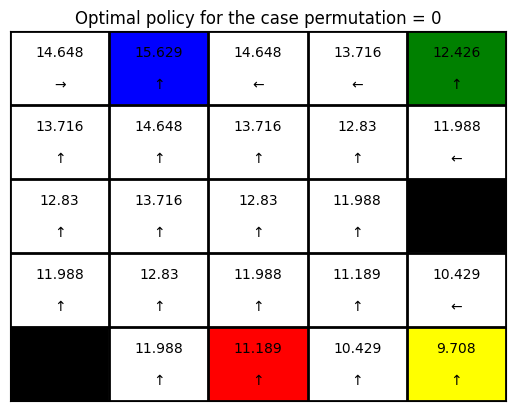

In [8]:
# Run the policy iteration with permutations
optimal_policy, values = run_policy_iteration_with_permutation(episodes=1000, gamma=gamma, permutation_probability=0)

# Optionally: Print the policy in grid format
policy_symbols = np.array([['↑', '↓', '←', '→'][optimal_policy[row, col]] for row in range(grid_size) for col in range(grid_size)])
policy_symbols = policy_symbols.reshape((grid_size, grid_size))
for state in black_squares:
    policy_symbols[state[0], state[1]] = 'X'


# Plot the data
plot_permu_0, ax_permu_0 = plot_value_policy(np.round(values, decimals=3), policy_symbols)
ax_permu_0.title.set_text('Optimal policy for the case permutation = 0')
plt.show()